In [211]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams["mathtext.fontset"] = 'dejavuserif'
import glob
from astropy.io import fits
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy.spatial import cKDTree
from astropy.cosmology import LambdaCDM, z_at_value
cosmo = LambdaCDM(H0=69.6, Om0=0.286, Ode0=0.714)
h = 69.6/100

from alignment_functions.clusters import *
from geometry_functions.coordinate_functions import *
from visualization_functions import *
from alignment_functions.general_stats import *

In [2]:
scratch_path = '/pscratch/sd/c/clamman/'

### Abacus

In [3]:
hod_mock = Table.read(scratch_path+'abacus/hod_catalogs/hod_catalog_ph000_z0.5000.fits')
hod_mock['DIST_COMOVING'] = cosmo.comoving_distance(hod_mock['Z_withRSD']).value*h

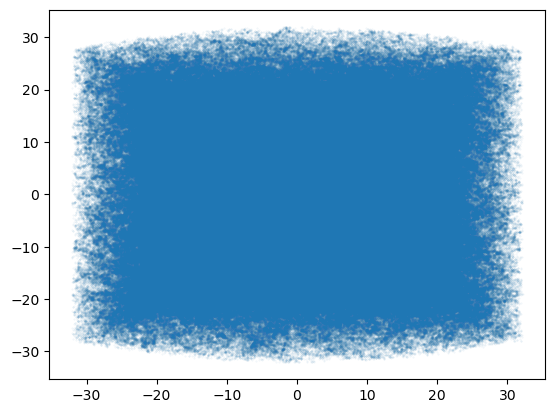

In [4]:
hod_mock['RA'] = wrap_180(hod_mock['RA'])
plt.scatter(hod_mock['RA'], hod_mock['DEC'], s=0.1, alpha=.1);

In [5]:
cluster_ii_abacus = find_cluster_2D(hod_mock, sky_sep_max=1e-4, los_max=1, max_n=5)

13861 members of clusters


Text(0, 0.5, 'DEC')

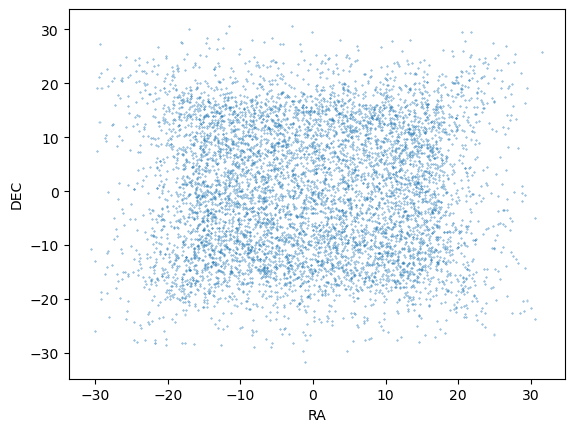

In [8]:
cluster_member_indices = np.unique(cluster_ii_abacus.flatten())
cluster_member_indices = cluster_member_indices[cluster_member_indices < len(hod_mock)]
print(len(cluster_member_indices), 'members of clusters')
plt.scatter(hod_mock['RA'][cluster_member_indices], hod_mock['DEC'][cluster_member_indices], s=0.1, alpha=.5);
plt.xlabel('RA')
plt.ylabel('DEC')

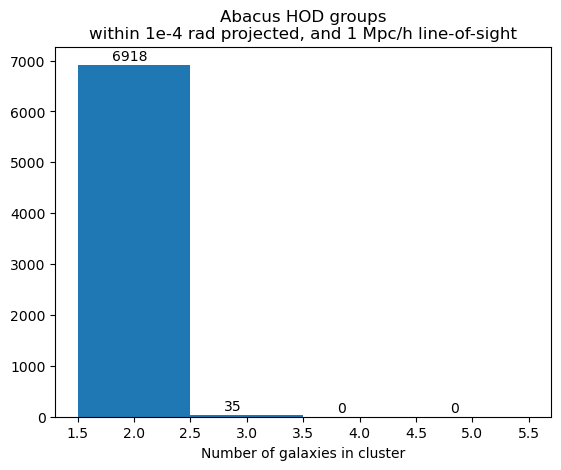

In [20]:
# number of galaxies in each cluster
# for each row in ii, count the number of unique indices
cluster_n = np.array([len(np.unique(row))-1 for row in cluster_ii_abacus])
cluster_count = plt.hist(cluster_n, bins=[1.5, 2.5, 3.5, 4.5, 5.5]);
plt.title('Abacus HOD groups\nwithin 1e-4 rad projected, and 1 Mpc/h line-of-sight')
plt.xlabel('Number of galaxies in cluster')
# print the count in each bin above the bin on the plot
for i in range(len(cluster_count[0])):
    plt.text(cluster_count[1][i]+.3, cluster_count[0][i]+80, str(int(cluster_count[0][i])))

### Above but with DESI

In [21]:
desi_catalog = Table.read(scratch_path+'Iron_LRG_noCircles.csv') 
desi_catalog.keep_columns(['RA', 'DEC', 'Z'])
desi_catalog['DIST_COMOVING'] = cosmo.comoving_distance(desi_catalog['Z']).value*h

In [22]:
cluster_ii_desi = find_cluster_2D(desi_catalog, sky_sep_max=1e-4, los_max=1, max_n=5)

Text(0, 0.5, 'DEC')

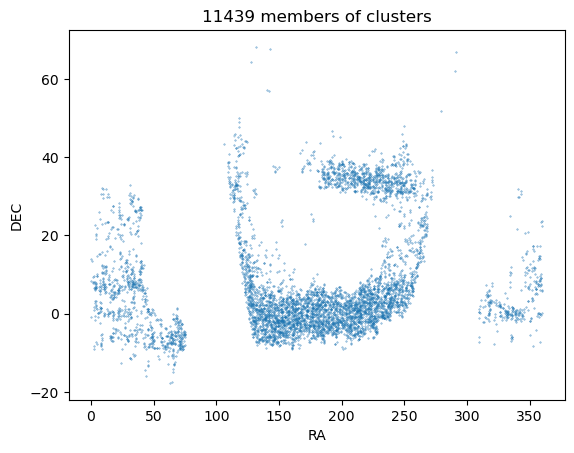

In [27]:
cluster_member_indices = np.unique(cluster_ii_desi.flatten())
cluster_member_indices = cluster_member_indices[cluster_member_indices < len(desi_catalog)]
plt.title(str(len(cluster_member_indices))+ ' members of clusters')
plt.scatter(desi_catalog['RA'][cluster_member_indices], desi_catalog['DEC'][cluster_member_indices], s=0.1, alpha=.5);
plt.xlabel('RA')
plt.ylabel('DEC')

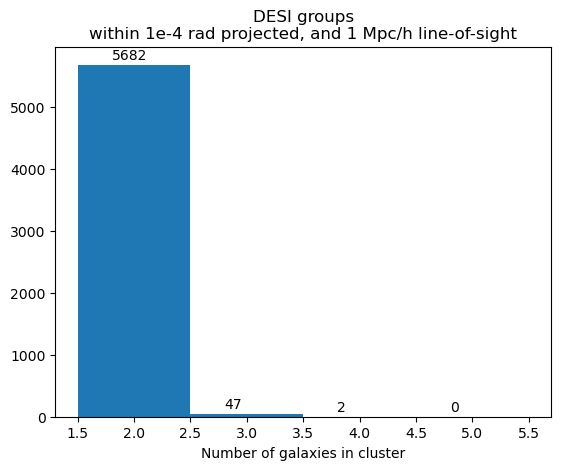

In [28]:
# number of galaxies in each cluster
# for each row in ii, count the number of unique indices
cluster_n = np.array([len(np.unique(row))-1 for row in cluster_ii_desi])
cluster_count = plt.hist(cluster_n, bins=[1.5, 2.5, 3.5, 4.5, 5.5]);
plt.title('DESI groups\nwithin 1e-4 rad projected, and 1 Mpc/h line-of-sight')
plt.xlabel('Number of galaxies in cluster')
# print the count in each bin above the bin on the plot
for i in range(len(cluster_count[0])):
    plt.text(cluster_count[1][i]+.3, cluster_count[0][i]+80, str(int(cluster_count[0][i])))

In [30]:
desi_catalog[cluster_ii_desi[((cluster_n > 3))][:,0]]

RA,DEC,Z,DIST_COMOVING
float64,float64,float64,float64
237.9018069829141,-0.12501884144141487,0.8733754273167245,2104.946352790683
336.69807846844105,1.4227162224159162,0.8356583682633141,2033.9705023149327


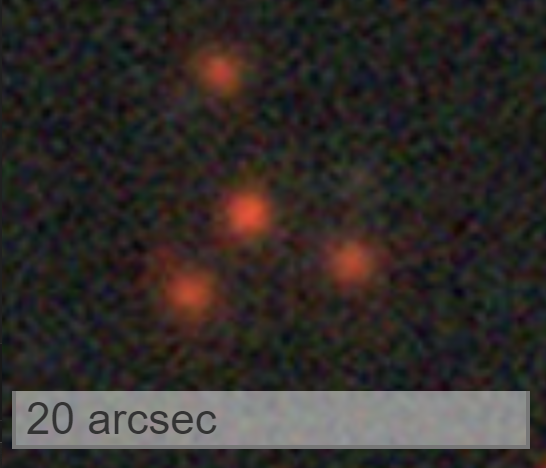

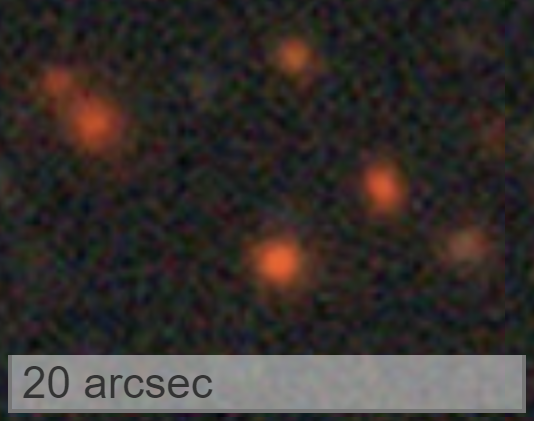

### Calculating pair alignment

In [188]:
def calculate_pair_alignment(catalog, sky_sep_max, los_max, proj_sep_max=.5, pimax=30, nbins=20):
    '''
    sky_sep_max in radians, los_max in Mpc/h
    for pairs relative to tracers, proj_sep_max in degrees on sky, pimax in Mpc/h
    '''
    
    # find pairs
    cluster_ii = find_cluster_2D(catalog, sky_sep_max=sky_sep_max, los_max=los_max, max_n=2)
    pairs_pa = calculate_pair_pa(catalog, cluster_ii)
    n_pairs = len(pairs_pa)
    
    # calculate alignment of pairs
    pairs_tracer_seps, pairs_tracers_paRel = calculate_rel_ang_ra_dec(pairs_pa, catalog, sep_max = deg_to_rad(proj_sep_max), sep_min=sky_sep_max, max_neighbors=1000, pimax=pimax)
    
    # binning results
    sep_bins = np.linspace(0, proj_sep_max, nbins)
    ang_plot, ang_plot_e = bin_sum_not_scipy(pairs_tracer_seps, np.cos(2*pairs_tracers_paRel), sep_bins, statistic='mean', err=True);
    return ang_plot, ang_plot_e, n_pairs

In [189]:
sky_sep_maxes = [.5e-4, 1e-4, 2e-4, 3e-4]
los_maxes = [.5, 1, 2, 3]

ang_plots = []
ang_plot_es = []
n_pairss = []

for j in range(len(los_maxes)):
    ang_plot, ang_plot_e, n_pairs = calculate_pair_alignment(desi_catalog, sky_sep_maxes[j], los_maxes[j])
    ang_plots.append(ang_plot)
    ang_plot_es.append(ang_plot_e)
    n_pairss.append(n_pairs)

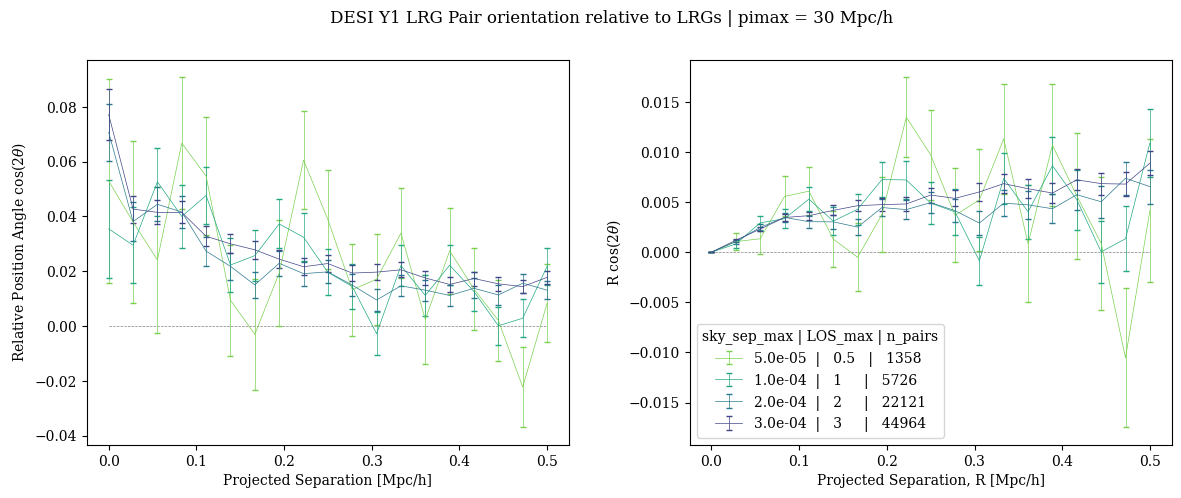

In [247]:
fig = plt.figure(figsize=(14,5))
proj_sep_max = .5
# make title of both subplots
plt.suptitle('DESI Y1 LRG Pair orientation relative to LRGs | pimax = 30 Mpc/h')
plt.subplots_adjust(wspace=.25)

plt.subplot(121)
plt.plot([0, .5], [0, 0], 'k--', alpha=.5, linewidth=.5)
plt.xlabel('Projected Separation [Mpc/h]')
plt.ylabel(r'Relative Position Angle cos(2$\theta$)')

plt.subplot(122)
plt.plot([0, .5], [0, 0], 'k--', alpha=.5, linewidth=.5)
plt.xlabel('Projected Separation, R [Mpc/h]')
plt.ylabel(r'R cos(2$\theta$)');

# make list of 5 gradient colors
colors = plt.cm.viridis_r(np.linspace(0.2, 1, 5))

nbins=20
xvalues = np.linspace(0, proj_sep_max, nbins-1)

plot_args = {'linewidth':.5, 'capsize':2}

for j in range(len(los_maxes)):
    
    plt.subplot(121)
    plt.errorbar(xvalues, ang_plots[j], yerr=ang_plot_es[j], color=colors[j], **plot_args)
    
    plt.subplot(122)
    plt.errorbar(xvalues, xvalues*ang_plots[j], yerr=xvalues*ang_plot_es[j], 
                label = '{}  |   {:<5} |   {}'.format("{:.1e}".format(sky_sep_maxes[j]), los_maxes[j], n_pairss[j]), color=colors[j], **plot_args)
    
    
plt.legend(title='sky_sep_max | LOS_max | n_pairs');

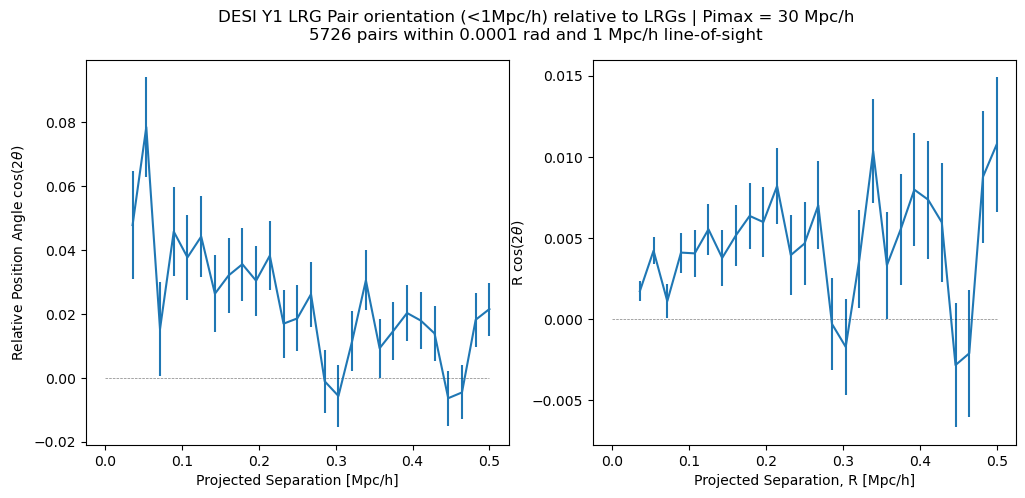

In [179]:
fig = plt.figure(figsize=(12,5))

# make title of both subplots
plt.suptitle('DESI Y1 LRG Pair orientation (<1Mpc/h) relative to LRGs | Pimax = ' + str(pimax) + 
             ' Mpc/h\n'+str(len(desi_pairs_pa))+ ' pairs within '+str(sky_sep_max)+' rad and '+str(los_max)+' Mpc/h line-of-sight')

lowerlim=2
xvalues = np.linspace(0, proj_sep_max, nbins-1)[lowerlim:]
yvalues = ang_plot[lowerlim:]

plt.subplot(121)
plt.errorbar(xvalues, yvalues, yerr=ang_plot_e[lowerlim:])
plt.xlabel('Projected Separation [Mpc/h]')
plt.ylabel(r'Relative Position Angle cos(2$\theta$)')
plt.plot([0, proj_sep_max], [0, 0], 'k--', alpha=.5, linewidth=.5)

plt.subplot(122)
plt.errorbar(xvalues, xvalues*yvalues, yerr=xvalues*ang_plot_e[lowerlim:])
plt.xlabel('Projected Separation, R [Mpc/h]')
plt.ylabel(r'R cos(2$\theta$)');
plt.plot([0, proj_sep_max], [0, 0], 'k--', alpha=.5, linewidth=.5)


--------------

#### Clusters relative to clusters

In [6]:
def calculate_rel_ang_cartesian(all_points, tree, center_points, sep_vectors, sep_max = 30, max_neighbors=100, pimax=30):
    '''no sky projection. sep_max and pimax in units of Mpc/h'''
    
    ci, ni, dd = find_pairs(center_points, tree, sep_max, k=max_neighbors, double=False, return_sep=True)
    
    print(np.shape(ci), np.shape(ni), np.shape(dd), np.shape(sep_vectors))
    # limit to pimax and ones with some separation
    to_keep = np.abs(all_points[ci,0] - all_points[ni,0]) < pimax
    to_keep &= (dd > 2)
    ci = ci[to_keep]; ni = ni[to_keep]
    
    # get projected sep and position angle
    proj_seps = np.sqrt((all_points[ci,1]-all_points[ni,1])**2 + (all_points[ci,2] - all_points[ni,2])**2)
    pa = np.arctan2((all_points[ci,2] - all_points[ni,2]), (all_points[ci,1]-all_points[ni,1]))
    orientation_angle = np.arctan2(sep_vectors[:,2], sep_vectors[:,1])[to_keep]
    pa_rel = orientation_angle - pa
    
    return proj_seps, np.abs(pa_rel)

In [7]:
proj_sep_max = 100
pimax = 40
cluster_tree = cKDTree(center_points)
cluster_seps, cluster_pa_rel = calculate_rel_ang_cartesian(abacus_catalog['x_L2com'], cluster_tree, center_points, sep_vectors, sep_max = proj_sep_max, max_neighbors=1000, pimax=pimax)

(20551918,) (20551918,) (20551918,) (197351, 3)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 197351 but corresponding boolean dimension is 20551918

In [ ]:
nbins = 30
sep_bins = np.linspace(0, proj_sep_max, nbins)
ang_plot, ang_plot_e = bin_sum_not_scipy(cluster_seps, np.cos(2*cluster_pa_rel), sep_bins, statistic='mean', err=True)

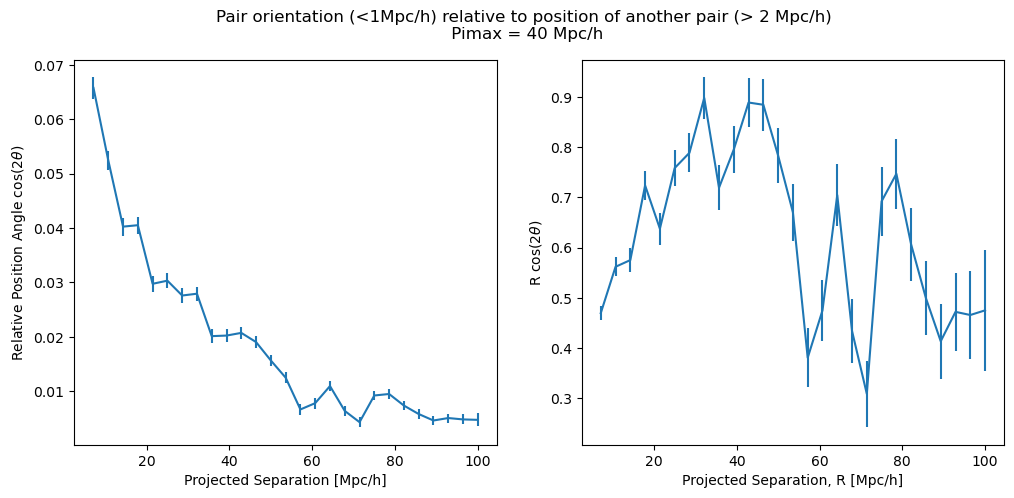

In [18]:
fig = plt.figure(figsize=(12,5))

# make title of both subplots
plt.suptitle('Abacus Pair orientation (<1Mpc/h) relative to position of another pair (> 2 Mpc/h)\n Pimax = ' + str(pimax) + ' Mpc/h')

lowerlim=2
xvalues = np.linspace(0, proj_sep_max, nbins-1)[lowerlim:]
yvalues = ang_plot[lowerlim:]

plt.subplot(121)
plt.errorbar(xvalues, yvalues, yerr=ang_plot_e[lowerlim:])
plt.xlabel('Projected Separation [Mpc/h]')
plt.ylabel(r'Relative Position Angle cos(2$\theta$)')

plt.subplot(122)
plt.errorbar(xvalues, xvalues*yvalues, yerr=xvalues*ang_plot_e[lowerlim:])
plt.xlabel('Projected Separation, R [Mpc/h]')
plt.ylabel(r'R cos(2$\theta$)');


### DESI

In [11]:
desi_catalog = Table.read('/global/cfs/cdirs/desi/users/clamman/catalogs/y1_comoving_coordinates.fits')

In [16]:
desi_catalog['Z'] = z_at_value(cosmo.comoving_distance, desi_catalog['distMpc']*u.Mpc)
desi_catalog['x_L2com'] = np.dstack(desi_catalog['X'], desi_catalog['Y'], desi_catalog['Z'])[0]

In [1]:
tree = cKDTree(desi_catalog['x_L2com'])

NameError: name 'cKDTree' is not defined

In [ ]:
center_points, sep_vectors = find_projected_pairs_cartesian(desi_catalog, tree, sep_max=1, n_in_cluster=2)

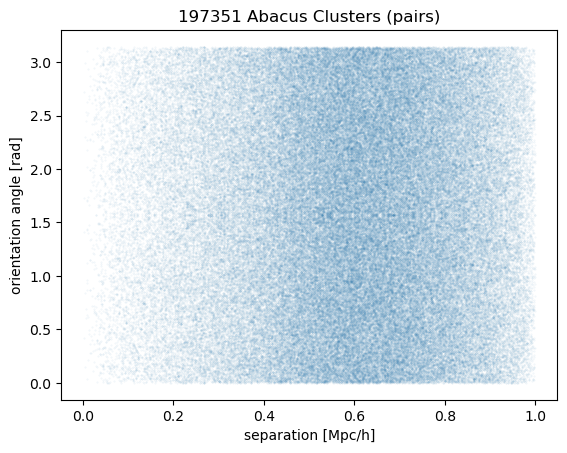

In [ ]:
plt.title(str(len(center_points)) + ' DESI Clusters (pairs)')
plt.xlabel('separation [Mpc/h]'); plt.ylabel('orientation angle [rad]')
plt.scatter(np.sqrt(sep_vectors[:,1]**2 + sep_vectors[:,2]**2), np.abs(np.arctan2(sep_vectors[:,2], sep_vectors[:,1])), s=.1, alpha=.1);

#### DESI Clusters relative to clusters

In [ ]:
def calculate_rel_ang_cartesian(center_points, tree, sep_vectors, sep_max = 30, max_neighbors=100, pimax=30):
    '''no sky projection. sep_max and pimax in units of Mpc/h'''
    
    ci, ni, dd = find_pairs(center_points, tree, sep_max, k=max_neighbors, double=False, return_sep=True)
    
    # limit to pimax and ones with some separation
    to_keep = np.abs(center_points[ci,0] - center_points[ni,0]) < pimax
    to_keep &= (dd > 2)
    ci = ci[to_keep]; ni = ni[to_keep]
    
    # get projected sep and position angle
    proj_seps = np.sqrt((center_points[ci,1]-center_points[ni,1])**2 + (center_points[ci,2] - center_points[ni,2])**2)
    pa = np.arctan2((center_points[ci,2] - center_points[ni,2]), (center_points[ci,1]-center_points[ni,1]))
    orientation_angle = np.arctan2(sep_vectors[ci,2], sep_vectors[ci,1])
    pa_rel = orientation_angle - pa
    
    return proj_seps, np.abs(pa_rel)

In [ ]:
proj_sep_max = 100
pimax = 40
cluster_tree = cKDTree(center_points)
cluster_seps, cluster_pa_rel = calculate_rel_ang_cartesian(desi_catalog['x_L2com'], cluster_tree, center_points, sep_vectors, sep_max = proj_sep_max, max_neighbors=1000, pimax=pimax)

(20551918,) (20551918,) (20551918,) (197351, 3)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 197351 but corresponding boolean dimension is 20551918

In [ ]:
nbins = 30
sep_bins = np.linspace(0, proj_sep_max, nbins)
ang_plot, ang_plot_e = bin_sum_not_scipy(cluster_seps, np.cos(2*cluster_pa_rel), sep_bins, statistic='mean', err=True)

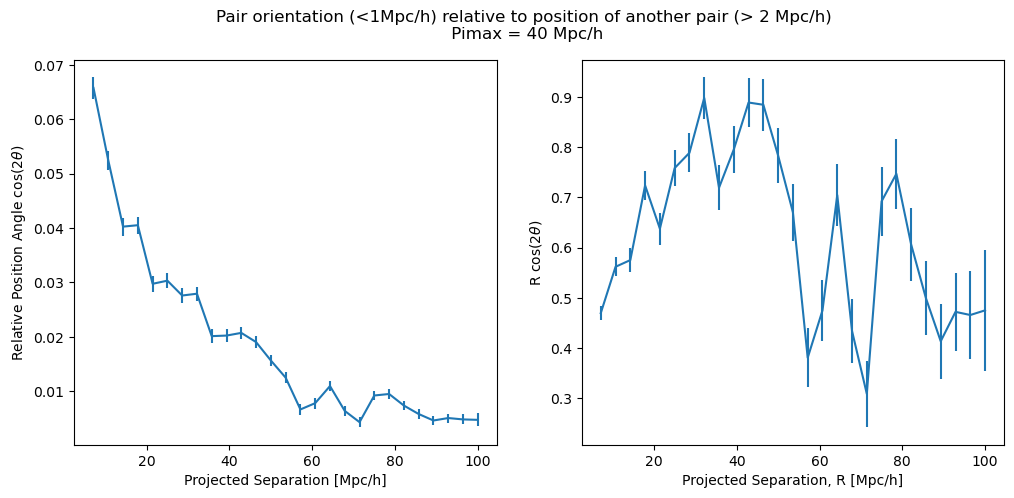

In [ ]:
fig = plt.figure(figsize=(12,5))

# make title of both subplots
plt.suptitle('DESI Y1 Pair orientation (<1Mpc/h) relative to position of another pair (> 2 Mpc/h)\n Pimax = ' + str(pimax) + ' Mpc/h')

lowerlim=2
xvalues = np.linspace(0, proj_sep_max, nbins-1)[lowerlim:]
yvalues = ang_plot[lowerlim:]

plt.subplot(121)
plt.errorbar(xvalues, yvalues, yerr=ang_plot_e[lowerlim:])
plt.xlabel('Projected Separation [Mpc/h]')
plt.ylabel(r'Relative Position Angle cos(2$\theta$)')

plt.subplot(122)
plt.errorbar(xvalues, xvalues*yvalues, yerr=xvalues*ang_plot_e[lowerlim:])
plt.xlabel('Projected Separation, R [Mpc/h]')
plt.ylabel(r'R cos(2$\theta$)');


#### Clusters relative to galaxies

In [ ]:
proj_sep_max = 100
pimax = 40
cluster_seps, cluster_pa_rel = calculate_rel_ang_cartesian(center_points, tree, sep_vectors, sep_max = proj_sep_max, max_neighbors=1000, pimax=pimax)

In [ ]:
nbins = 30
sep_bins = np.linspace(0, proj_sep_max, nbins)
ang_plot, ang_plot_e = bin_sum_not_scipy(cluster_seps, np.cos(2*cluster_pa_rel), sep_bins, statistic='mean', err=True)

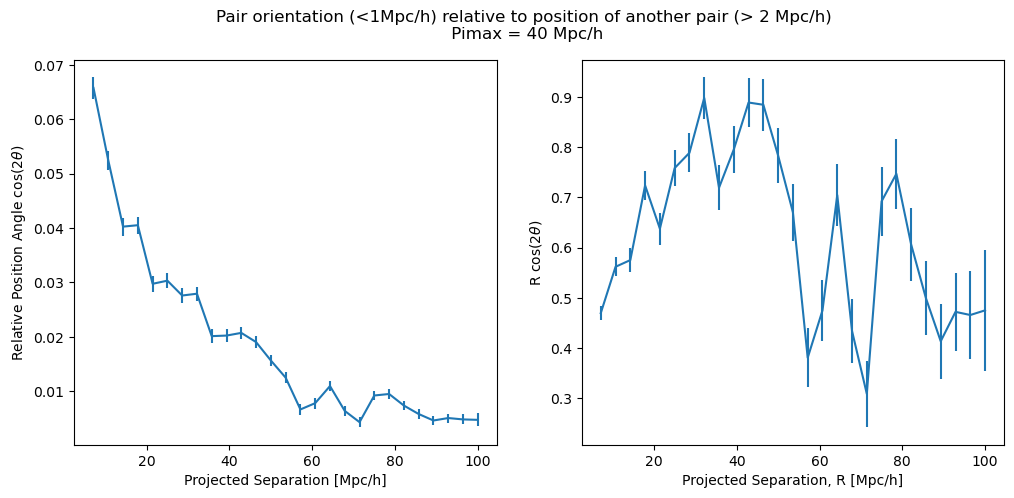

In [ ]:
fig = plt.figure(figsize=(12,5))

# make title of both subplots
plt.suptitle('Pair orientation (<1Mpc/h) relative to position of another pair (> 2 Mpc/h)\n Pimax = ' + str(pimax) + ' Mpc/h')

lowerlim=2
xvalues = np.linspace(0, proj_sep_max, nbins-1)[lowerlim:]
yvalues = ang_plot[lowerlim:]

plt.subplot(121)
plt.errorbar(xvalues, yvalues, yerr=ang_plot_e[lowerlim:])
plt.xlabel('Projected Separation [Mpc/h]')
plt.ylabel(r'Relative Position Angle cos(2$\theta$)')

plt.subplot(122)
plt.errorbar(xvalues, xvalues*yvalues, yerr=xvalues*ang_plot_e[lowerlim:])
plt.xlabel('Projected Separation, R [Mpc/h]')
plt.ylabel(r'R cos(2$\theta$)');
